In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.optim import Adam
from torchvision.transforms import  Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop, Lambda
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics
from lightning.pytorch.loggers import WandbLogger
import wandb
import random
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [27]:
import helper_functions as hp

PRICES_FILE_PATH = "../Dataset/prices.txt"
DATASET_PATHS_TEST = ["../Dataset/test"]
MODEL_CHECKPOINT = "./checkpoints/custom_local_data_Efficientnet_18Jan-17:47:07.ckpt"
BATCH_SIZE_TEST = 1
IMAGE_SIZE = (200, 200)

num_clases = hp.get_num_clases(PRICES_FILE_PATH)
prices = hp.get_combined_dict(PRICES_FILE_PATH)
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 2
print(device)


cuda


In [5]:
class TrainModel(pl.LightningModule):
    def __init__(self, model, prices, learning_rate=1e-3, optimizer=None):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.model = model
        self.prices = prices
        self.criterion = nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        self.optimizer = optimizer
        self.threshold = 0.5
        self.save_hyperparameters() #ignore=['model']

    def forward(self, x):
        return self.model(x)

    def calculate_total_price(self, predictions, labels):
        """
        Berechnet den Gesamtpreis basierend auf den Vorhersagen und tatsächlichen Labels
        """
        # Vorhersagen und tatsächliche Labels basierend auf Threshold filtern
        predicted_labels = [i for i, pred in enumerate(predictions) if pred > self.threshold]
        true_labels = [i for i, label in enumerate(labels) if label > 0.5]

        # Berechnung der Gesamtpreise
        predicted_price = sum(self.prices[label][1] for label in predicted_labels if label in self.prices)
        true_price = sum(self.prices[label][1] for label in true_labels if label in self.prices)

        return predicted_price, true_price

    def step(self, batch, stage):
        x, y = batch
        y_pred = self(x)  # Vorhersagen

        # Hauptverlust berechnen (MSE auf allen Labels)
        loss = self.criterion(y_pred, y)

        # MAE und MSE der Hauptlabels
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Berechnung der Gesamtpreise
        batch_predicted_prices = []
        batch_true_prices = []
        for i in range(len(y)):
            predicted_price, true_price = self.calculate_total_price(y_pred[i], y[i])
            batch_predicted_prices.append(predicted_price)
            batch_true_prices.append(true_price)

        # Manuelle Berechnung von MAE und MSE für Gesamtpreise
        total_mae = sum(abs(tp - pp) for tp, pp in zip(batch_true_prices, batch_predicted_prices)) / len(batch_true_prices)
        total_mse = sum((tp - pp) ** 2 for tp, pp in zip(batch_true_prices, batch_predicted_prices)) / len(batch_true_prices)

        # Logs für Progress-Bar und Training/Validierung/Test
        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_mae", mae, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_mse", mse, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_total_mae", total_mae, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_total_mse", total_mse, prog_bar=True, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, stage="val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, stage="test")

    def configure_optimizers(self):
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Scheduler erstellen
        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.965)
        return [self.optimizer], [scheduler]


In [42]:
from torchvision.models import efficientnet_b0

def getEfficientnetRegression():
    # Load EfficientNet-B0 with pretrained weights
    model = efficientnet_b0(weights="IMAGENET1K_V1")
    print(model)

    # Replace head
    output = model.features[-1][0].out_channels  # Output channels of the last block

    # Define custom regression head
    regression_head = nn.Sequential(
        nn.Linear(output, 200),  # Adjust input size as needed
        nn.ReLU(),
        nn.Linear(200, 200),
        nn.ReLU(),
        nn.Linear(200, 100),
        nn.ReLU(),
        nn.Linear(100, num_clases)
    )

    # Replace the classifier with your regression head
    model.classifier = regression_head
    return model

model = TrainModel.load_from_checkpoint(MODEL_CHECKPOINT)

# Modell auf die entsprechende Hardware verschieben
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             864
       BatchNorm2d-2         [-1, 32, 100, 100]              64
              SiLU-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 32, 100, 100]             288
       BatchNorm2d-5         [-1, 32, 100, 100]              64
              SiLU-6         [-1, 32, 100, 100]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 100, 100]               0
           Conv2d-13         [-1, 16, 100, 100]             512
      BatchNorm2d-14         [-1, 16, 1

/home/torgeschwark/miniconda3/envs/MLubu/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


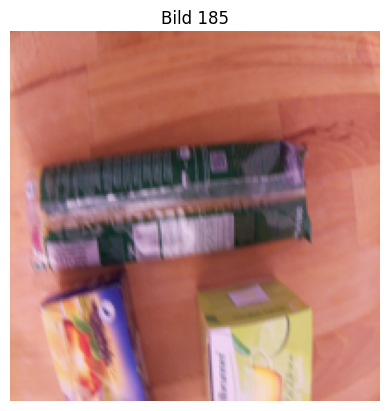

Vorhersage für Bild 185:
  Klasse 0: 0.0497
  Klasse 1: -0.0294
  Klasse 2: 0.0254
  Klasse 3: -0.0719
  Klasse 4: -0.0408
  Klasse 5: 0.3181
  Klasse 6: 0.0085
  Klasse 7: -0.0232
  Klasse 8: -0.0242
  Klasse 9: 0.5136
  Klasse 10: -0.0457
  Klasse 11: 0.0152
  Klasse 12: -0.0229
  Klasse 13: 0.2265
  Klasse 14: 0.0084
  Klasse 15: 0.0194
  Klasse 16: 0.0300
  Klasse 17: -0.0272
  Klasse 18: -0.0196
  Klasse 19: 0.0203
  Klasse 20: -0.0003
  Klasse 21: -0.0180
  Klasse 22: 0.0134
  Klasse 23: -0.0287
  Klasse 24: 0.0048
  Klasse 25: 0.0141
  Klasse 26: 1.9377
  Klasse 27: 0.0133
  Klasse 28: 0.0016
  Klasse 29: 0.0333
  Klasse 30: 0.0097
  Klasse 31: -0.0589
  Klasse 32: -0.0325
  Klasse 33: -0.0525
  Klasse 34: 0.0242
  Klasse 35: -0.0262
  Klasse 36: -0.0210
  Klasse 37: 0.0268
  Klasse 38: -0.0186
  Klasse 39: -0.0157
  Klasse 40: 0.0158
  Klasse 41: 0.0413
  Klasse 42: 0.0293
  Klasse 43: -0.0547
  Klasse 44: 0.0358
  Klasse 45: -0.0356
  Klasse 46: 0.0159
  Klasse 47: -0.0213
  K

In [43]:
class ImagePriceDataset(Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.files = []
        for dataset_path in dataset_paths:
            if not os.path.exists(dataset_path):
                raise ValueError(f"Path {dataset_path} doesn't exist.")
            for f in os.listdir(dataset_path):
                if f.endswith(".jpg"):
                    self.files.append((f, dataset_path))
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name, dataset_path = self.files[idx]
        image, label = hp.load_image_labeles_classify(file_name, dataset_path, IMAGE_SIZE, num_clases)

        # Wenn das Bild im float32 Format vorliegt, skaliere es und wandle es in uint8 um
        if image.dtype == np.float32:
            image = (image * 255).astype(np.uint8)  # Skalieren auf [0, 255] und in uint8 umwandeln

        # Konvertiere das numpy-Array in ein PIL-Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

transform_test = Compose([
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

test_dataset = ImagePriceDataset(DATASET_PATHS_TEST, transform_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=num_workers)

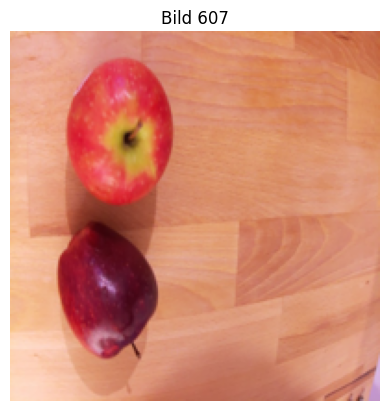

Layer 1: Conv2d - Feature Map Shape: torch.Size([1, 32, 100, 100]), Anzahl der Filter: 32


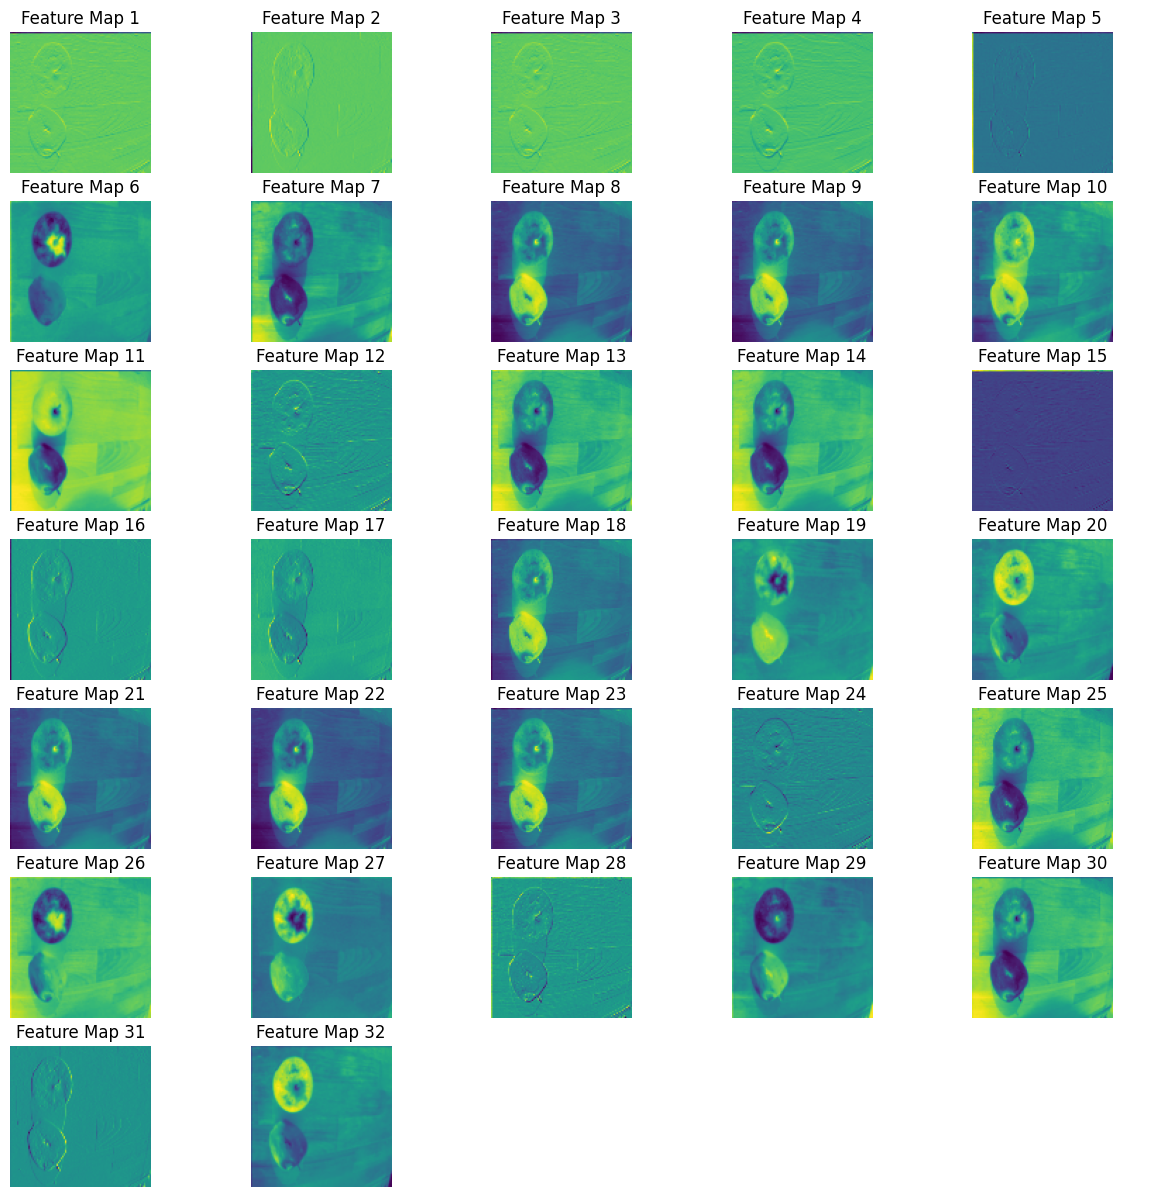

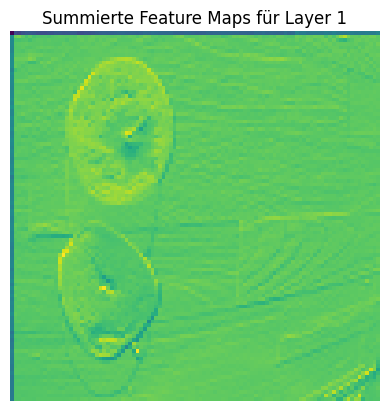

Layer 2: MBConv - Feature Map Shape: torch.Size([1, 16, 100, 100]), Anzahl der Filter: 16


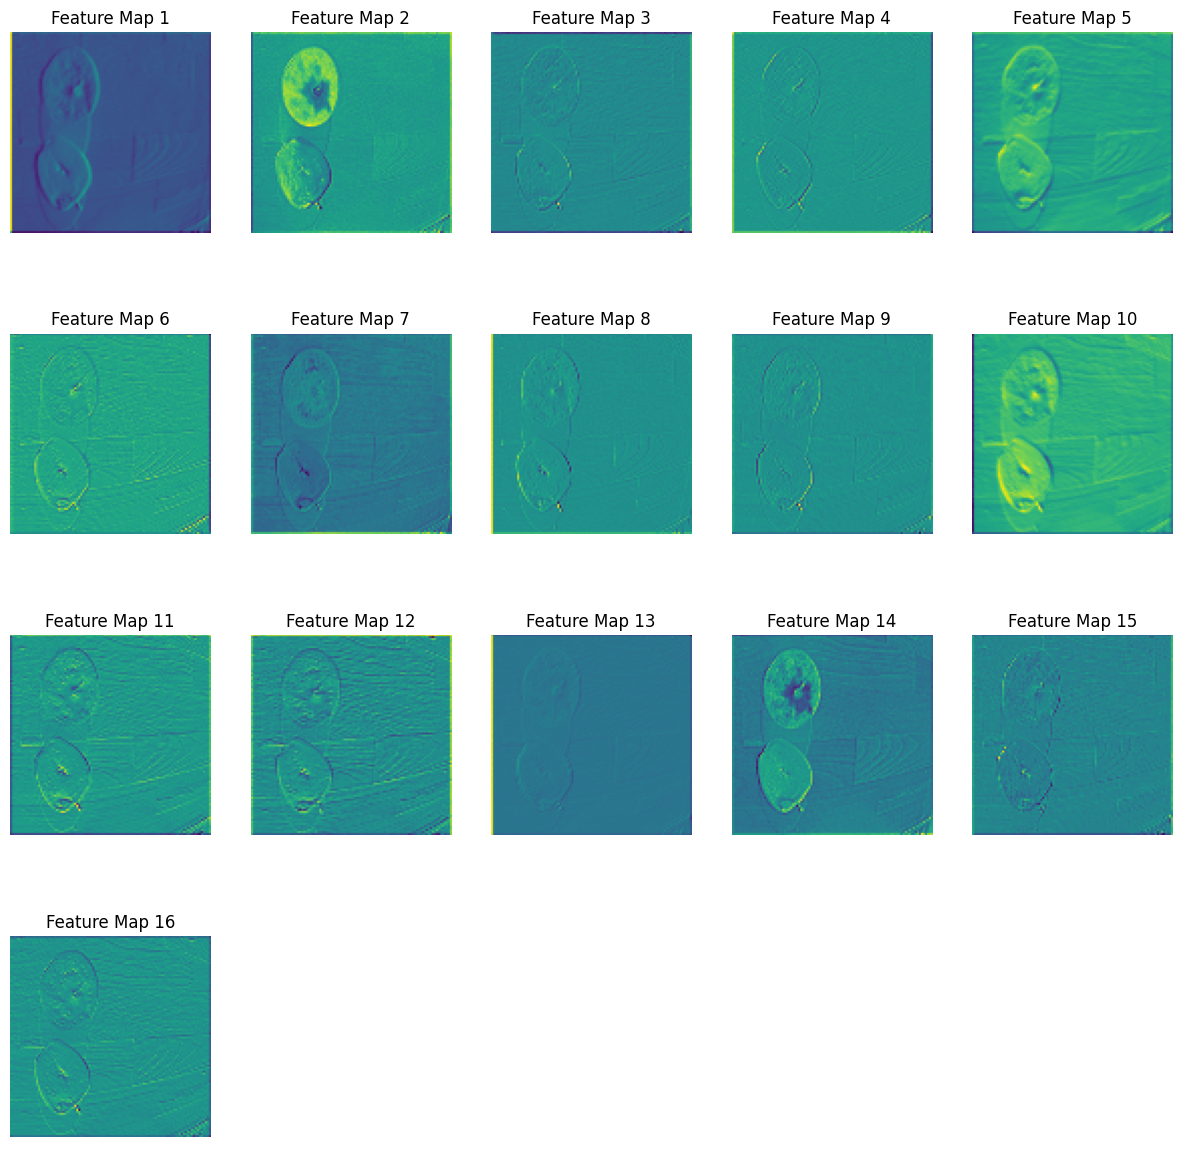

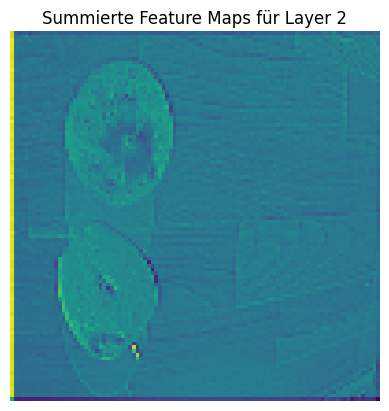

Layer 3: MBConv - Feature Map Shape: torch.Size([1, 24, 50, 50]), Anzahl der Filter: 24


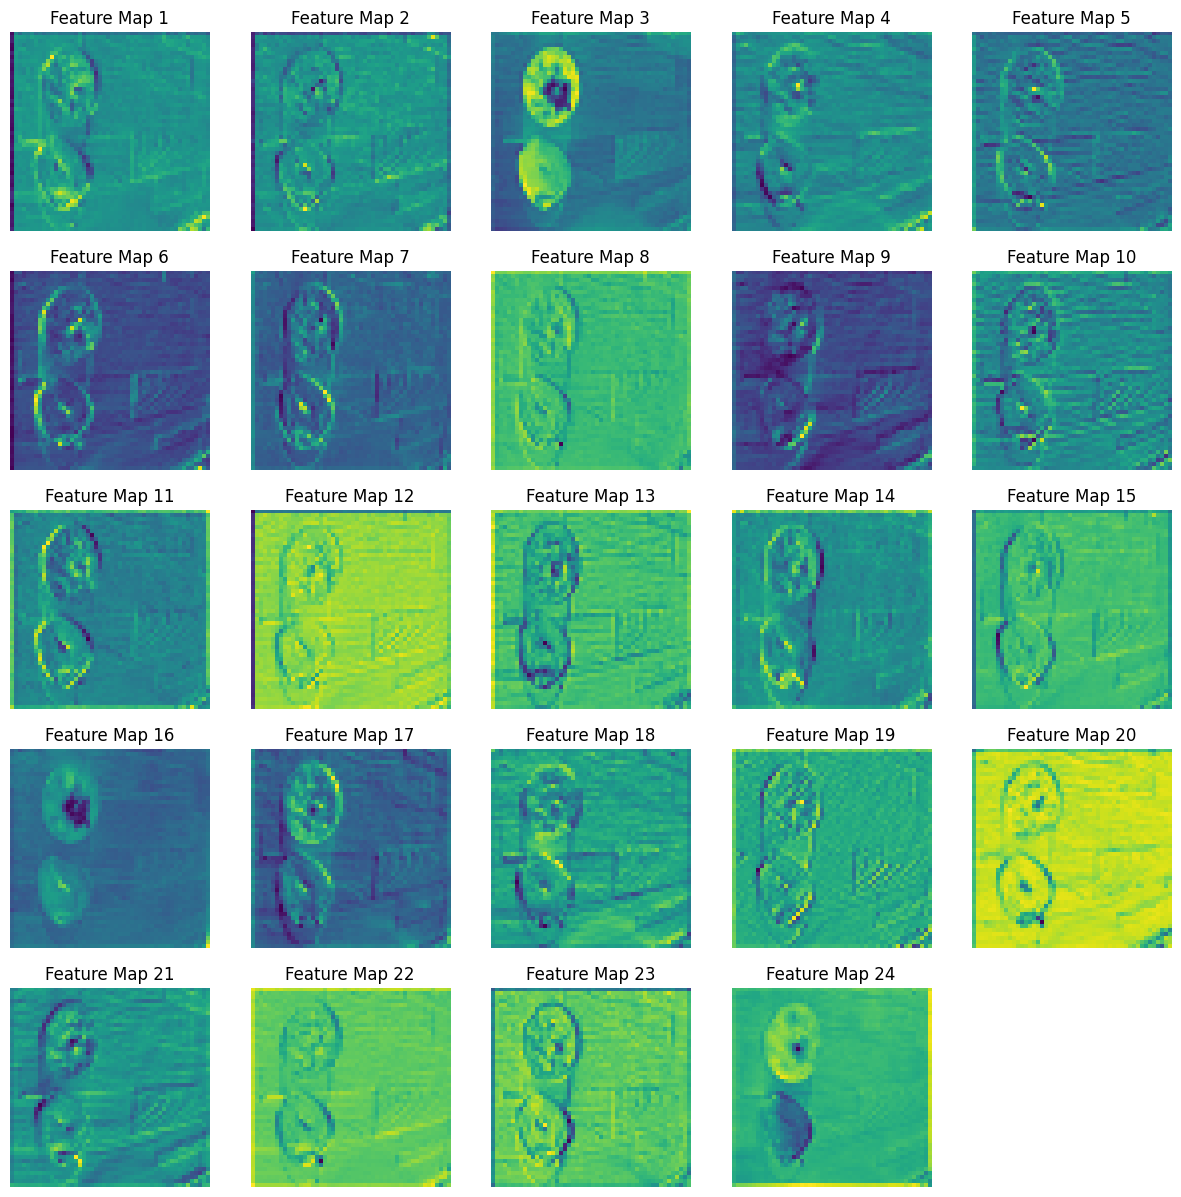

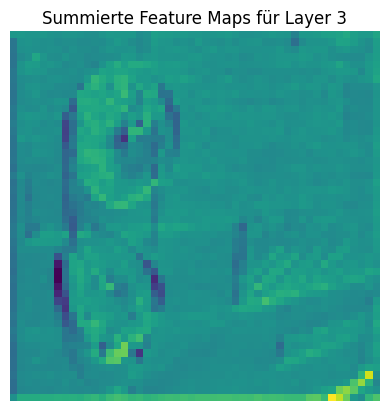

Layer 4: MBConv - Feature Map Shape: torch.Size([1, 40, 25, 25]), Anzahl der Filter: 40


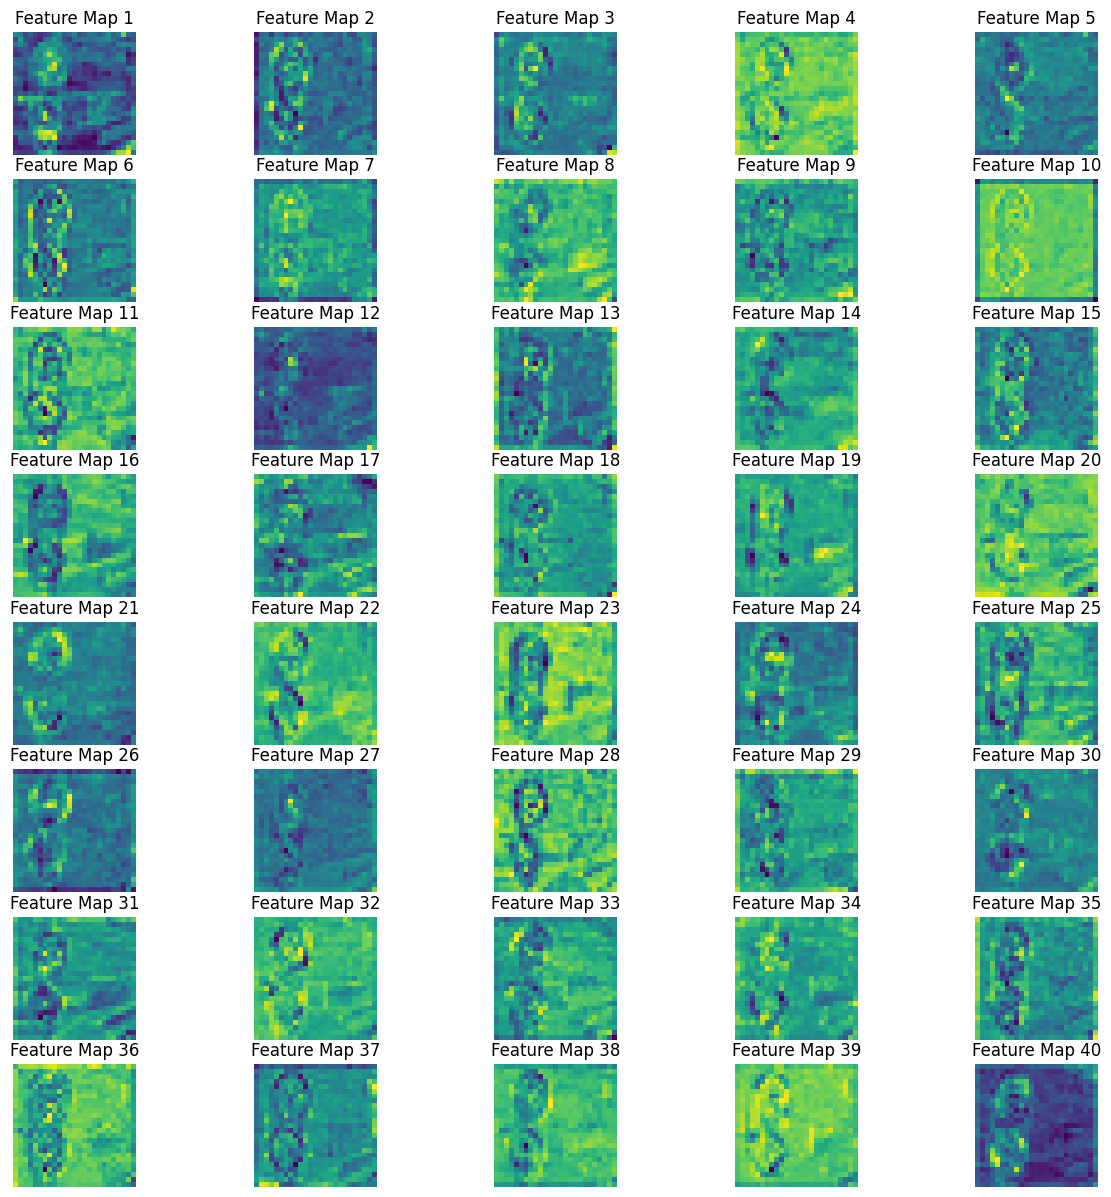

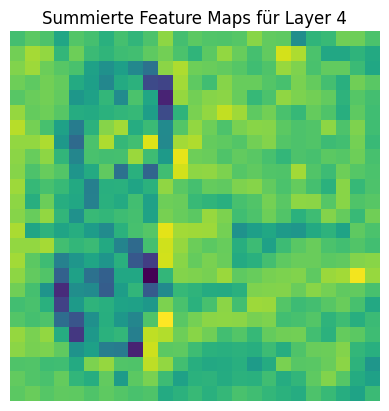

Layer 5: MBConv - Feature Map Shape: torch.Size([1, 80, 13, 13]), Anzahl der Filter: 80


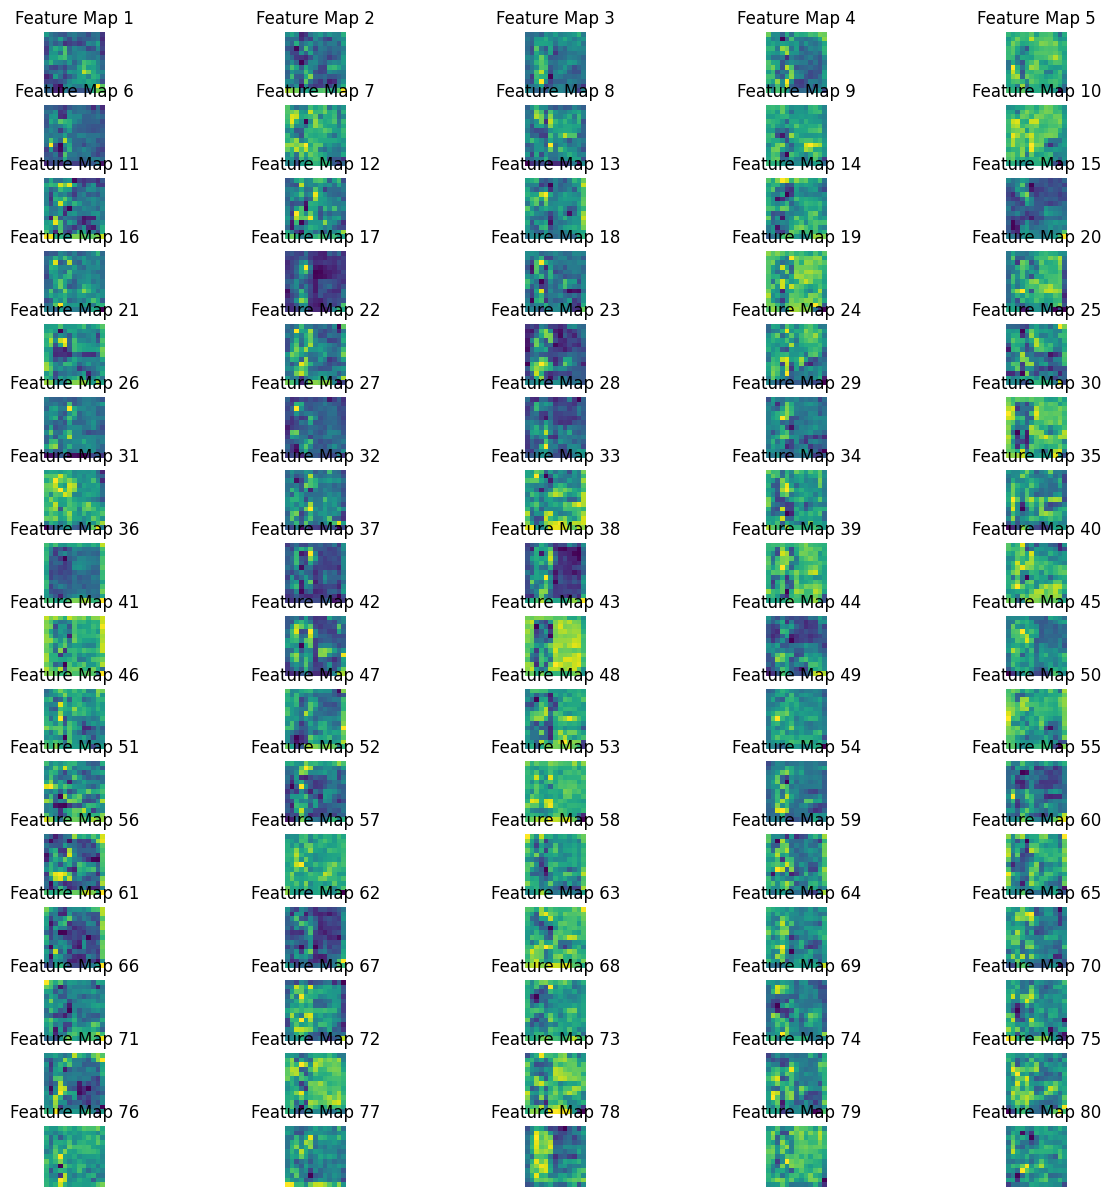

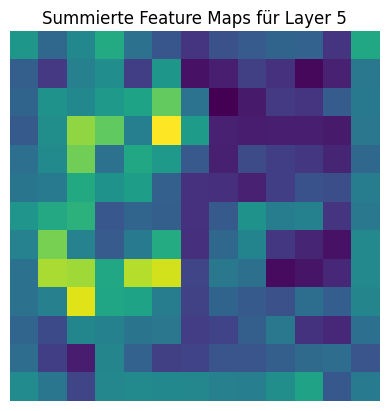

Layer 6: MBConv - Feature Map Shape: torch.Size([1, 112, 13, 13]), Anzahl der Filter: 112


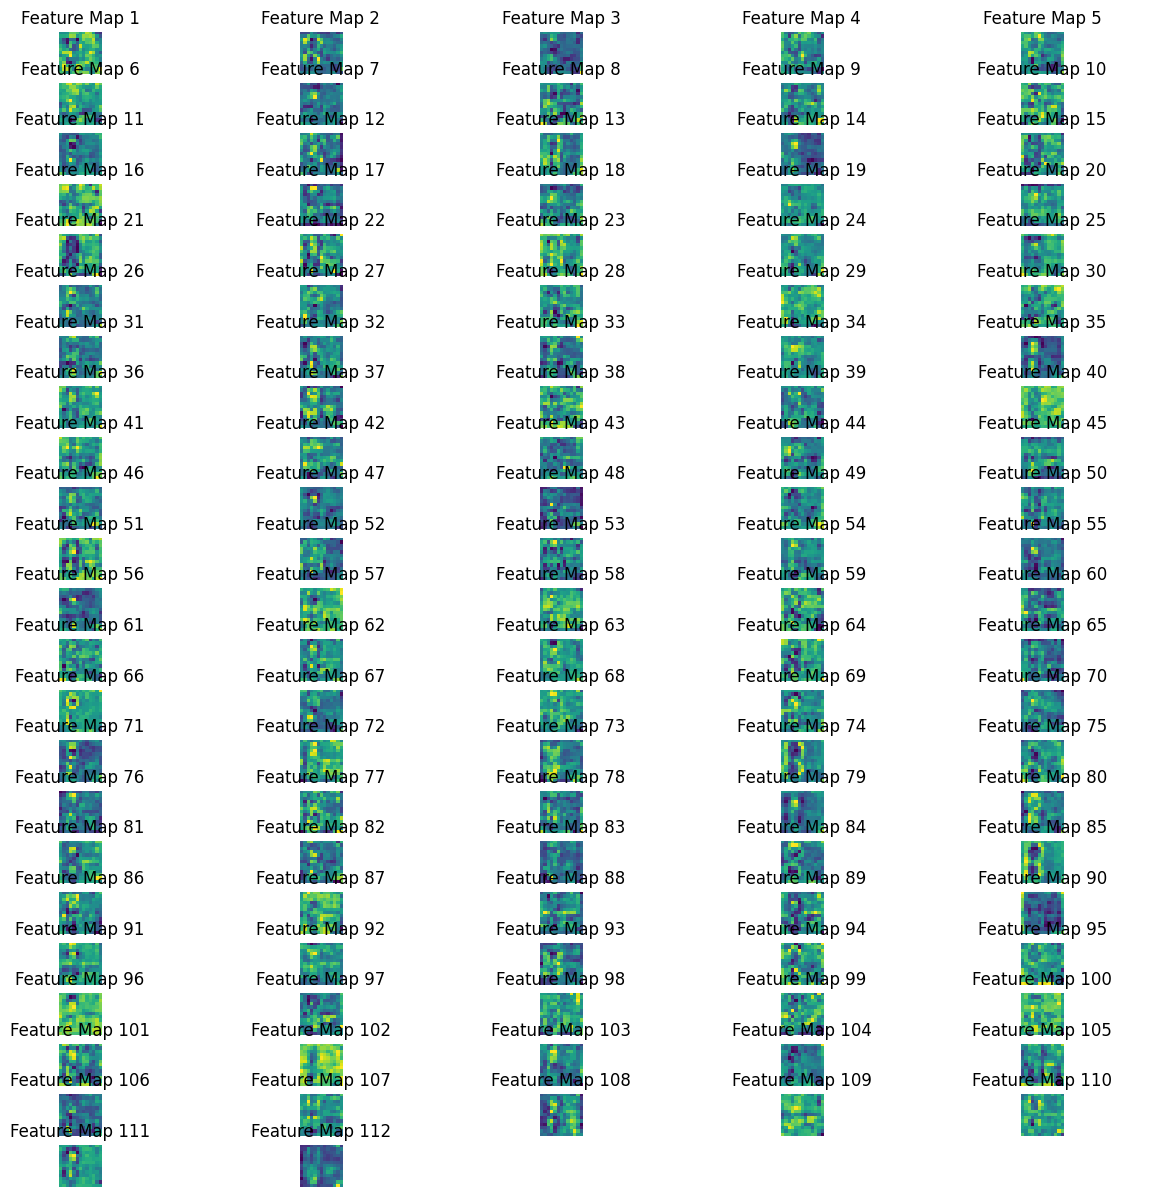

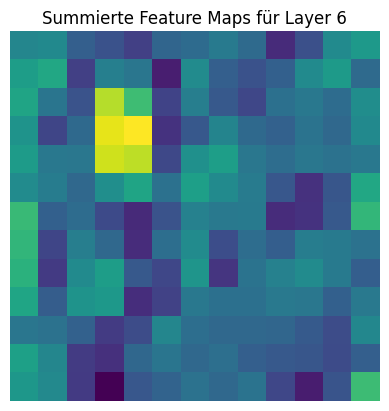

Layer 7: MBConv - Feature Map Shape: torch.Size([1, 192, 7, 7]), Anzahl der Filter: 192


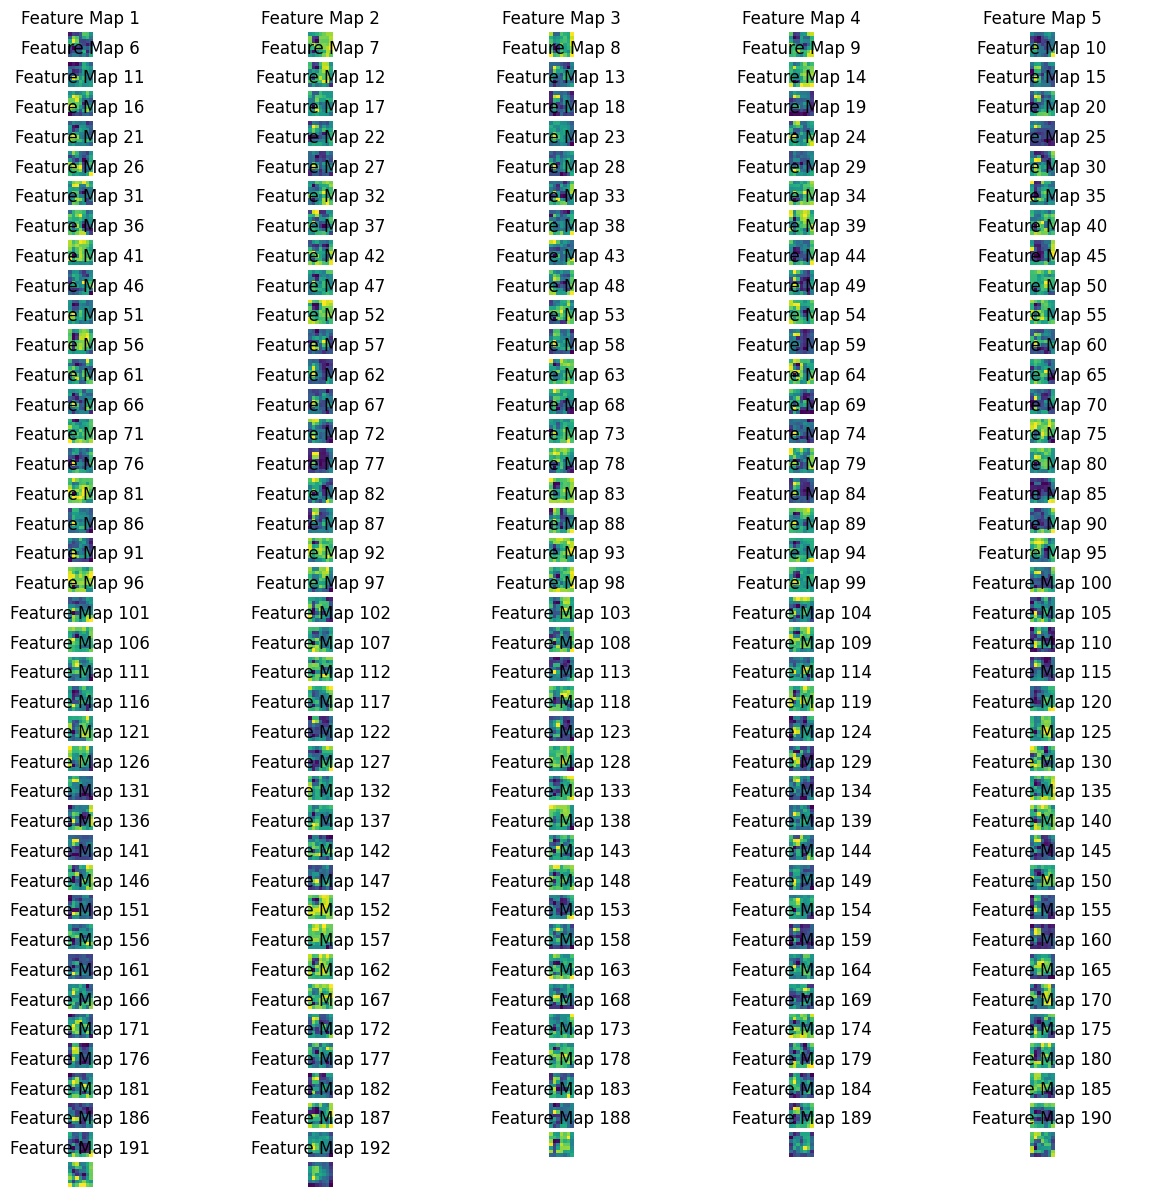

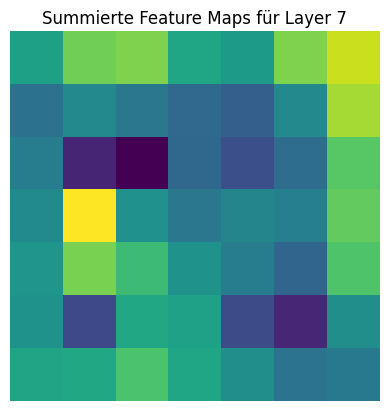

Layer 8: MBConv - Feature Map Shape: torch.Size([1, 320, 7, 7]), Anzahl der Filter: 320


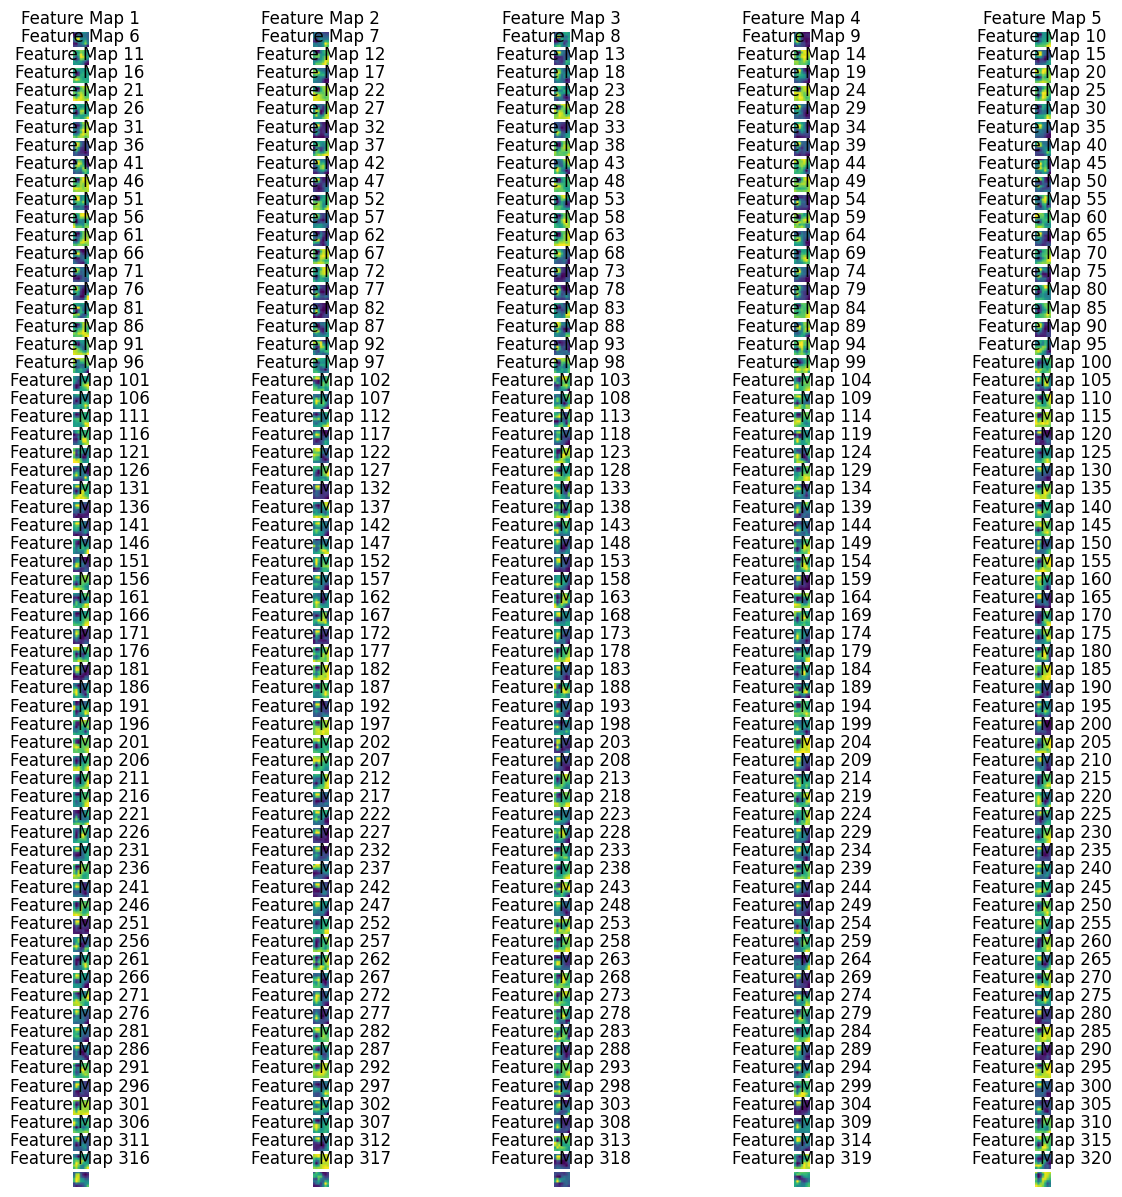

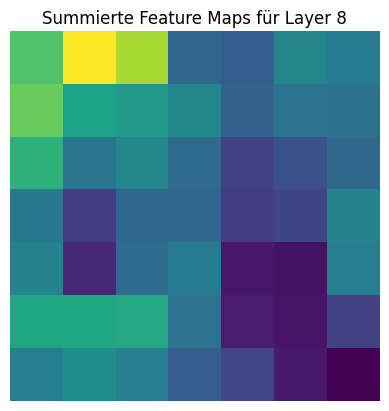

Layer 9: Conv2d - Feature Map Shape: torch.Size([1, 1280, 7, 7]), Anzahl der Filter: 1280


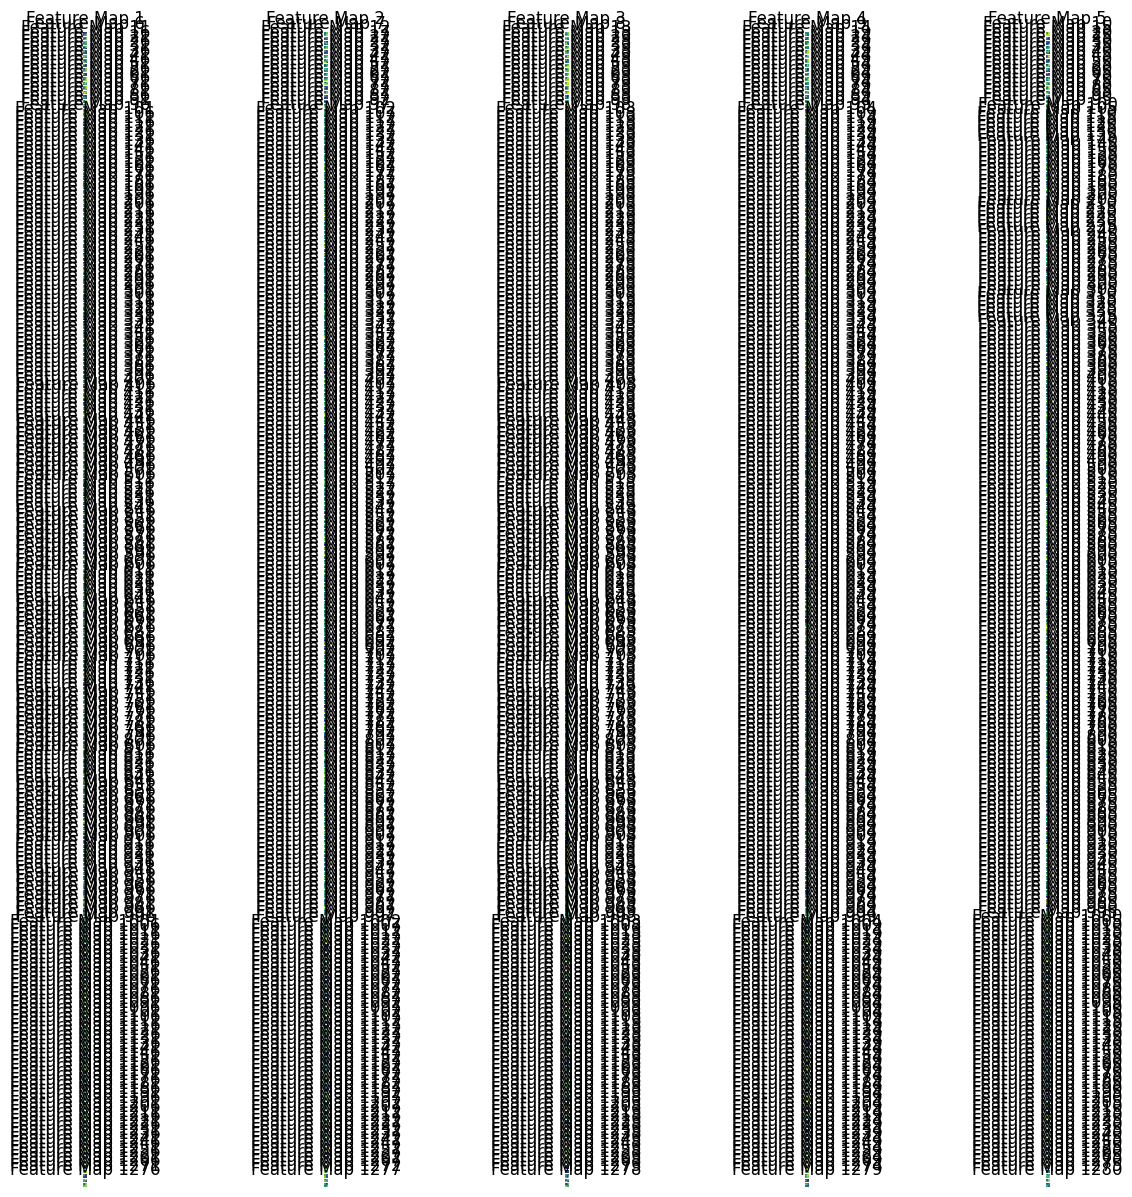

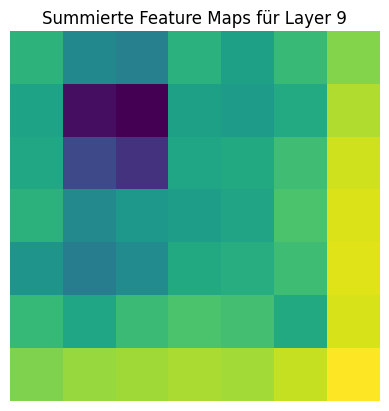

In [55]:
import torch
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b0
import random

# Hook-Funktion definieren, um den Output nach jedem Layer zu speichern
def hook_fn(module, input, output):
    # Speichere die Feature Maps für den aktuellen Layer
    feature_maps.append((module.__class__.__name__, output))  # Speichern des Layernamens und des Outputs

# Modell laden
model = efficientnet_b0(pretrained=True)

# Modell in den Evaluierungsmodus setzen
model.eval()

# Liste zur Speicherung der Feature Maps
feature_maps = []

# Liste zur Speicherung der Hook-Objekte
hooks = []

# Alle Layers im 'features' Modul durchgehen und Hook registrieren
for idx, layer in enumerate(model.features):
    # Registrierung eines Hooks für jedes Layer
    hook = layer[0].register_forward_hook(hook_fn)  # Nur der erste Sub-Layer im Block ist der eigentliche Conv2dNormActivation Layer
    hooks.append(hook)

# Zufälligen Index auswählen
image_index = random.randint(0, len(test_dataset) - 1)  # Zufälliges Bild aus dem Datensatz

# Hole das Bild und Label aus dem Dataset
image, label = test_dataset[image_index]

# Zeige das Bild an (vor der Transformation in einen Batch)
plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # (C, H, W) -> (H, W, C) und auf CPU verschieben
plt.title(f"Bild {image_index + 1}")
plt.axis("off")
plt.show()

# Bild auf Batch-Größe 1 erweitern
image = image.unsqueeze(0)  # (C, H, W) -> (1, C, H, W)

# Bild auf die entsprechende Hardware verschieben
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
image = image.to(device)

# Vorhersage durch das Modell (dies wird den Hook auslösen)
output = model(image)

# Alle Hooks nach dem Forward Pass entfernen
for hook in hooks:
    hook.remove()

# Feature Maps und Anzahl der Filter ausgeben
for idx, (layer_name, fmap) in enumerate(feature_maps):
    num_filters = fmap.size(1)  # Anzahl der Filter im aktuellen Layer
    print(f"Layer {idx + 1}: {layer_name} - Feature Map Shape: {fmap.shape}, Anzahl der Filter: {num_filters}")
    
    # Berechne, wie viele Spalten und Reihen für die Visualisierung benötigt werden
    rows = (num_filters + 4) // 5  # Berechne die Anzahl der Zeilen (mindestens 5 pro Reihe)
    cols = min(5, num_filters)  # Maximal 5 Spalten (für 25 Feature Maps)

    # Visualisiere die Feature Maps im Layout von 5x5 (wenn so viele vorhanden sind)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    
    # Falls weniger als 25 Feature Maps vorhanden sind, wird die Achse auf "off" gesetzt
    if rows == 1 or cols == 1:
        axes = [axes]  # Falls nur eine Zeile oder eine Spalte vorhanden ist, mache die Achse zu einer Liste

    # Alle Feature Maps visualisieren
    for i in range(num_filters):  # Alle Feature Maps visualisieren
        ax = axes[i // cols][i % cols]  # Zeilen und Spalten aufteilen
        ax.imshow(fmap[0, i].cpu().detach().numpy(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Feature Map {i+1}")
    
    # Falls weniger als 25 Feature Maps vorhanden sind, werden die restlichen Subplots ausgeblendet
    for j in range(num_filters, rows * cols):
        axes[j // cols][j % cols].axis('off')

    plt.show()

    # Optional: Alle Feature Maps aufsummieren
    summed_feature_map = fmap.sum(dim=1)  # Summiere alle Feature Maps auf (nach der Filter-Achse)
    plt.imshow(summed_feature_map[0].cpu().detach().numpy(), cmap='viridis')
    plt.title(f"Summierte Feature Maps für Layer {idx + 1}")
    plt.axis("off")
    plt.show()
